# 📖 Import Libraries


In [1]:
import pandas as pd
import numpy as np
import re
import sys

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display

# 🔑 Functions

In [15]:
# utils
def to_snake_case(
    col
):
  """
  Convert a string to snake case.

  Args:
    col: A string to convert to snake case.

  Returns:
    A string in snake case.
  """
  col = col.strip().lower()
  col = re.sub(r'[\s\-]+', '_', col)
  col = re.sub(r'([a-z])([A-Z])', r'\1_\2', col)
  col = re.sub(r'[^a-z0-9_]', '', col)

  return col

def lowercase_strings(df: pd.DataFrame) -> pd.DataFrame:
    """
    Converts all string/object columns in a DataFrame to lowercase.
    """
    for col in df.columns:
        if pd.api.types.is_object_dtype(df[col]) or pd.api.types.is_string_dtype(df[col]):
            df[col] = df[col].astype(str).str.lower()
    return df

def markdown(
    text: str
):
  """
  Display a markdown string.

  Args:
    text: A markdown string to display.
  """
  display(Markdown(text))

# analysis
def clean_and_prepare_data(df):
    """Clean and prepare our data for analysis"""

    # Make a copy to avoid modifying original
    df_clean = df.copy()

    # Convert dates and times
    df_clean['date'] = pd.to_datetime(df_clean['date'])
    df_clean['datetime'] = pd.to_datetime(df_clean['date'].astype(str) + ' ' + df_clean['time'].astype(str))

    # Extract time features
    df_clean['hour'] = df_clean['datetime'].dt.hour
    df_clean['day_of_week'] = df_clean['datetime'].dt.day_name()
    df_clean['month'] = df_clean['datetime'].dt.month
    df_clean['is_weekend'] = df_clean['datetime'].dt.weekday >= 5

    # Clean numeric columns
    numeric_cols = ['booking_value', 'ride_distance', 'driver_ratings', 'customer_rating']
    for col in numeric_cols:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

    # Create helpful flags
    df_clean['is_successful'] = df_clean['booking_status'] == 'completed'
    df_clean['is_cancelled_customer'] = df_clean['cancelled_rides_by_customer'].notna()
    df_clean['is_cancelled_driver'] = df_clean['cancelled_rides_by_driver'].notna()

    # Categorize booking status
    def categorize_status(status):
        if status == 'completed':
            return 'completed'
        elif 'cancelled' in str(status):
            return 'cancelled'
        elif status == 'no driver found':
            return 'no driver found'
        else:
            return 'other'

    df_clean['status_category'] = df_clean['booking_status'].apply(categorize_status)

    return df_clean

def create_executive_summary(df):
    """Generate key business metrics with median values"""
    total_rides = len(df)
    successful_rides = df['is_successful'].sum()
    success_rate = (successful_rides / total_rides) * 100

    total_revenue = df[df['is_successful']]['booking_value'].sum()
    median_ride_value = df[df['is_successful']]['booking_value'].median()

    median_distance = df[df['is_successful']]['ride_distance'].median()
    median_driver_rating = df[df['is_successful']]['driver_ratings'].median()
    median_customer_rating = df[df['is_successful']]['customer_rating'].median()

    # Cancellation analysis
    customer_cancellations = df['is_cancelled_customer'].sum()
    driver_cancellations = df['is_cancelled_driver'].sum()

    return {
        'total_rides': total_rides,
        'successful_rides': successful_rides,
        'success_rate': success_rate,
        'total_revenue': total_revenue,
        'median_ride_value': median_ride_value,
        'median_distance': median_distance,
        'median_driver_rating': median_driver_rating,
        'median_customer_rating': median_customer_rating,
        'customer_cancellations': customer_cancellations,
        'driver_cancellations': driver_cancellations
    }

def count_outliers(df, columns):
    """
    Count outliers in each column using the IQR method.
    Returns a DataFrame with outlier counts and percentages.
    """
    outlier_counts = []

    total_rows = len(df)

    for col in columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
            outlier_percent = (outliers / total_rows) * 100
            outlier_counts.append({
                "Column": col,
                "Outlier Count": outliers,
                "Outlier Percent": round(outlier_percent, 2)
            })

    return pd.DataFrame(outlier_counts)

def missing_values_summary(df: pd.DataFrame) -> pd.DataFrame:
    """
    Returns a summary DataFrame showing the count and percentage
    of missing values for each column in the given DataFrame.
    """
    total_rows = len(df)
    summary = []

    for col in df.columns:
        missing_count = df[col].isnull().sum()
        missing_percent = (missing_count / total_rows) * 100
        summary.append({
            'column': col,
            'missing_count': missing_count,
            'missing_percent': round(missing_percent, 2)
        })

    summary_df = pd.DataFrame(summary)
    return summary_df.sort_values(by='missing_count', ascending=False).reset_index(drop=True)

# ⚙️ Preprocessing

## ⬇️ Import Dataset and Fix Column Names

In [3]:
base_uber_df=pd.read_csv('/content/ncr_ride_bookings.csv')
base_uber_df.columns = [to_snake_case(col) for col in base_uber_df.columns]

markdown(f"""
<h1>📈 Dataset Overview</h1>
"""
)
base_uber_df.head()


<h1>📈 Dataset Overview</h1>


,date,time,booking_id,booking_status,customer_id,vehicle_type,pickup_location,drop_location,avg_vtat,avg_ctat,...,reason_for_cancelling_by_customer,cancelled_rides_by_driver,driver_cancellation_reason,incomplete_rides,incomplete_rides_reason,booking_value,ride_distance,driver_ratings,customer_rating,payment_method
0,2024-03-23,12:29:38,"""CNR5884300""",No Driver Found,"""CID1982111""",eBike,Palam Vihar,Jhilmil,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-11-29,18:01:39,"""CNR1326809""",Incomplete,"""CID4604802""",Go Sedan,Shastri Nagar,Gurgaon Sector 56,4.9,14.0,...,NaN,NaN,NaN,1.0,Vehicle Breakdown,237.0,5.73,NaN,NaN,UPI
2,2024-08-23,08:56:10,"""CNR8494506""",Completed,"""CID9202816""",Auto,Khandsa,Malviya Nagar,13.4,25.8,...,NaN,NaN,NaN,NaN,NaN,627.0,13.58,4.9,4.9,Debit Card
3,2024-10-21,17:17:25,"""CNR8906825""",Completed,"""CID2610914""",Premier Sedan,Central Secretariat,Inderlok,13.1,28.5,...,NaN,NaN,NaN,NaN,NaN,416.0,34.02,4.6,5.0,UPI
4,2024-09-16,22:08:00,"""CNR1950162""",Completed,"""CID9933542""",Bike,Ghitorni Village,Khan Market,5.3,19.6,...,NaN,NaN,NaN,NaN,NaN,737.0,48.21,4.1,4.3,UPI


## 📜 Data Overview

In [4]:
columns_list = "\n".join([f"    • {col}" for col in base_uber_df.columns])

markdown(f"""
<h1>📈 Dataset Overview</h1>


<h2>📊 Dataset Shape:</h2>

{columns_list}
<h2>📅 This data are from <b>{base_uber_df['date'].min()}</b> to <b>{base_uber_df['date'].max()}</b>.</h2>
<h2>📊 Dataset Columns: <b>{base_uber_df.shape[1]} Columns</b></h2>
<h2>📊 Dataset Rows: <b>{base_uber_df.shape[0]} Rows</b></h2>
""")


<h1>📈 Dataset Overview</h1>


<h2>📊 Dataset Shape:</h2>

    • date
    • time
    • booking_id
    • booking_status
    • customer_id
    • vehicle_type
    • pickup_location
    • drop_location
    • avg_vtat
    • avg_ctat
    • cancelled_rides_by_customer
    • reason_for_cancelling_by_customer
    • cancelled_rides_by_driver
    • driver_cancellation_reason
    • incomplete_rides
    • incomplete_rides_reason
    • booking_value
    • ride_distance
    • driver_ratings
    • customer_rating
    • payment_method
<h2>📅 This data are from <b>2024-01-01</b> to <b>2024-12-30</b>.</h2>
<h2>📊 Dataset Columns: <b>21 Columns</b></h2>
<h2>📊 Dataset Rows: <b>150000 Rows</b></h2>


## 🧵 Adjust String Values

In [5]:
clean_uber_df=lowercase_strings(base_uber_df)

# **🧐 Adjust String Process**

it converts all values to strings (if they aren’t already) and then transforms them to lowercase. The purpose of this step is to standardize text data, ensuring consistency by removing variations caused by capitalization. This makes tasks like text comparison, grouping, or merging more reliable, as 'Completed', 'completed', and 'COMPLETED' would all become 'completed'.


---


## **TL;DR**
**This process standardizes all text columns by converting their values to lowercase strings, ensuring consistency for easier comparison and analysis.**

## 🪄 Data Manipulation

In [14]:
clean_uber_df=clean_and_prepare_data(clean_uber_df)

markdown(f"""
<h1>🔮 Data Manipulation Result</h1>
"""
)
clean_uber_df.head()


<h1>🔮 Data Manipulation Result</h1>


,date,time,booking_id,booking_status,customer_id,vehicle_type,pickup_location,drop_location,avg_vtat,avg_ctat,...,payment_method,datetime,hour,day_of_week,month,is_weekend,is_successful,is_cancelled_customer,is_cancelled_driver,status_category
0,2024-03-23,12:29:38,"""cnr5884300""",no driver found,"""cid1982111""",ebike,palam vihar,jhilmil,NaN,NaN,...,nan,2024-03-23 12:29:38,12,Saturday,3,True,False,False,False,no driver found
1,2024-11-29,18:01:39,"""cnr1326809""",incomplete,"""cid4604802""",go sedan,shastri nagar,gurgaon sector 56,4.9,14.0,...,upi,2024-11-29 18:01:39,18,Friday,11,False,False,False,False,other
2,2024-08-23,08:56:10,"""cnr8494506""",completed,"""cid9202816""",auto,khandsa,malviya nagar,13.4,25.8,...,debit card,2024-08-23 08:56:10,8,Friday,8,False,True,False,False,completed
3,2024-10-21,17:17:25,"""cnr8906825""",completed,"""cid2610914""",premier sedan,central secretariat,inderlok,13.1,28.5,...,upi,2024-10-21 17:17:25,17,Monday,10,False,True,False,False,completed
4,2024-09-16,22:08:00,"""cnr1950162""",completed,"""cid9933542""",bike,ghitorni village,khan market,5.3,19.6,...,upi,2024-09-16 22:08:00,22,Monday,9,False,True,False,False,completed


# **🧐 Data Manipulation Process**

The preprocessing starts by converting the date column into a proper datetime format and then creating a combined datetime column by merging the date and time columns. This allows for easier extraction of time-based features. From this datetime column, several features are derived: the hour of the booking, the day of the week, the month, and whether the booking occurred on a weekend.

Next, numeric columns such as booking_value, ride_distance, driver_ratings, and customer_rating are cleaned by converting them to numeric types, with any invalid values coerced into NaN.

The code also creates helpful flags to simplify analysis. The is_successful flag identifies bookings that were completed, while is_cancelled_customer and is_cancelled_driver indicate bookings cancelled by the customer or the driver, respectively.

Finally, booking statuses are categorized into simplified groups. Bookings that were completed remain as 'completed', any booking containing the word “cancelled” is marked as 'cancelled', bookings where no driver was found are labeled 'no driver found', and all other cases fall under 'other'.

## **TL;DR**
**this preprocessing prepares the dataset by cleaning and standardizing key columns, creating informative flags, and extracting temporal features, making it ready for further analysis or modeling.**

# 📊 Summary and Simple Statistical Analysis

## ❗Perform Executive Summary

In [7]:
metrics = create_executive_summary(clean_uber_df)

# Render in Markdown
display(Markdown(f"""
# 🎯 Executive Summary (Median-Based)

* 📊 **Total Rides Analyzed:** {metrics['total_rides']:,}
* ✅ **Successful Rides:** {metrics['successful_rides']:,}
* 📈 **Success Rate:** {metrics['success_rate']:.1f}%
* 💰 **Total Revenue:** ₹{metrics['total_revenue']:,.0f}
* 💵 **Median Ride Value:** ₹{metrics['median_ride_value']:.0f}
* 🛣️ **Median Distance:** {metrics['median_distance']:.1f} km
* ⭐ **Median Driver Rating:** {metrics['median_driver_rating']:.2f}/5
* ⭐ **Median Customer Rating:** {metrics['median_customer_rating']:.2f}/5
* ❌ **Customer Cancellations:** {metrics['customer_cancellations']:,}
* 🚫 **Driver Cancellations:** {metrics['driver_cancellations']:,}
"""))


# 🎯 Executive Summary (Median-Based)

* 📊 **Total Rides Analyzed:** 150,000
* ✅ **Successful Rides:** 93,000
* 📈 **Success Rate:** 62.0%
* 💰 **Total Revenue:** ₹47,260,574
* 💵 **Median Ride Value:** ₹414
* 🛣️ **Median Distance:** 26.0 km
* ⭐ **Median Driver Rating:** 4.30/5
* ⭐ **Median Customer Rating:** 4.50/5
* ❌ **Customer Cancellations:** 10,500
* 🚫 **Driver Cancellations:** 27,000


## ❓ Checking Missing Values

In [23]:
missing_summary = missing_values_summary(clean_uber_df)
missing_md_bullets = "\n".join([
    f"* ⚠️ **{row['column']}**: {row['missing_count']:,} missing ({row['missing_percent']:.1f}%)"
    for _, row in missing_summary.iterrows()
])


markdown(f"""
<h1>📋 Missing Values Summary</h1>

{missing_md_bullets}
""")


<h1>📋 Missing Values Summary</h1>

* ⚠️ **incomplete_rides**: 141,000 missing (94.0%)
* ⚠️ **cancelled_rides_by_customer**: 139,500 missing (93.0%)
* ⚠️ **cancelled_rides_by_driver**: 123,000 missing (82.0%)
* ⚠️ **driver_ratings**: 57,000 missing (38.0%)
* ⚠️ **customer_rating**: 57,000 missing (38.0%)
* ⚠️ **avg_ctat**: 48,000 missing (32.0%)
* ⚠️ **booking_value**: 48,000 missing (32.0%)
* ⚠️ **ride_distance**: 48,000 missing (32.0%)
* ⚠️ **avg_vtat**: 10,500 missing (7.0%)
* ⚠️ **booking_status**: 0 missing (0.0%)
* ⚠️ **vehicle_type**: 0 missing (0.0%)
* ⚠️ **customer_id**: 0 missing (0.0%)
* ⚠️ **date**: 0 missing (0.0%)
* ⚠️ **time**: 0 missing (0.0%)
* ⚠️ **driver_cancellation_reason**: 0 missing (0.0%)
* ⚠️ **reason_for_cancelling_by_customer**: 0 missing (0.0%)
* ⚠️ **drop_location**: 0 missing (0.0%)
* ⚠️ **pickup_location**: 0 missing (0.0%)
* ⚠️ **booking_id**: 0 missing (0.0%)
* ⚠️ **incomplete_rides_reason**: 0 missing (0.0%)
* ⚠️ **payment_method**: 0 missing (0.0%)
* ⚠️ **datetime**: 0 missing (0.0%)
* ⚠️ **hour**: 0 missing (0.0%)
* ⚠️ **day_of_week**: 0 missing (0.0%)
* ⚠️ **month**: 0 missing (0.0%)
* ⚠️ **is_weekend**: 0 missing (0.0%)
* ⚠️ **is_successful**: 0 missing (0.0%)
* ⚠️ **is_cancelled_customer**: 0 missing (0.0%)
* ⚠️ **is_cancelled_driver**: 0 missing (0.0%)
* ⚠️ **status_category**: 0 missing (0.0%)


# **🧐 Why not drop?**

Columns `avg_ctat`, `avg_vtat`, `ride_distance`, and `booking_value` are key metrics that indicate whether a service actually took place. NULL values in these columns suggest a problem with the booking, such as cancellations by the customer or driver. Therefore, these values are important and should not be deleted, as they may indicate errors that need to be analyzed.

Meanwhile, columns `incomplete_rides`, `cancelled_rides_by_customer`, and `cancelled_rides_by_driver` are effects derived from the main metrics. A NULL value in these columns indicates that the order proceeded normally without any issues, so NULL here is not an error and should be retained.

For `customer_rating` and `driver_rating`, NULL values mean that the respective party did not provide a rating. This is also not an error but valid information about user behavior.


---


## **TL;DR**

**handling NULL values should depend on the context of each column: for main metrics, NULL may indicate an error, while for status or rating columns, NULL conveys meaningful information and should be preserved.**

## 📈 Perform Statitical Overview

In [9]:
markdown(f"""
<h1>📊 Statistical Overview</h1>
"""
)
clean_uber_df.describe()


<h1>📊 Statistical Overview</h1>


,date,avg_vtat,avg_ctat,cancelled_rides_by_customer,cancelled_rides_by_driver,incomplete_rides,booking_value,ride_distance,driver_ratings,customer_rating,datetime,hour,month
count,150000,139500.000000,102000.000000,10500.0,27000.0,9000.0,102000.000000,102000.000000,93000.000000,93000.000000,150000,150000.000000,150000.000000
mean,2024-06-30 16:42:40.320000,8.456352,29.149636,1.0,1.0,1.0,508.295912,24.637012,4.230992,4.404584,2024-07-01 07:14:41.251033344,14.034113,6.490940
min,2024-01-01 00:00:00,2.000000,10.000000,1.0,1.0,1.0,50.000000,1.000000,3.000000,3.000000,2024-01-01 00:19:34,0.000000,1.000000
25%,2024-03-31 00:00:00,5.300000,21.600000,1.0,1.0,1.0,234.000000,12.460000,4.100000,4.200000,2024-03-31 22:55:36.249999872,10.000000,3.000000
50%,2024-07-01 00:00:00,8.300000,28.800000,1.0,1.0,1.0,414.000000,23.720000,4.300000,4.500000,2024-07-01 09:24:52.500000,15.000000,7.000000
75%,2024-09-30 00:00:00,11.300000,36.800000,1.0,1.0,1.0,689.000000,36.820000,4.600000,4.800000,2024-09-30 13:46:07.249999872,18.000000,9.000000
max,2024-12-30 00:00:00,20.000000,45.000000,1.0,1.0,1.0,4277.000000,50.000000,5.000000,5.000000,2024-12-30 23:36:11,23.000000,12.000000
std,NaN,3.773564,8.902577,0.0,0.0,0.0,395.805774,14.002138,0.436871,0.437819,NaN,5.416906,3.444028


## 🟢 Initialize Columns to Visualize

In [10]:
cols_to_hist = [
    "avg_ctat", "ride_distance",
    "booking_value", "avg_vtat"
]

cols_to_box_plot = [
    'avg_vtat', 'avg_ctat',
    'booking_value', 'ride_distance',
]

## 📈 Checking The Data Distribution

<h1>📊 Histograms</h1>

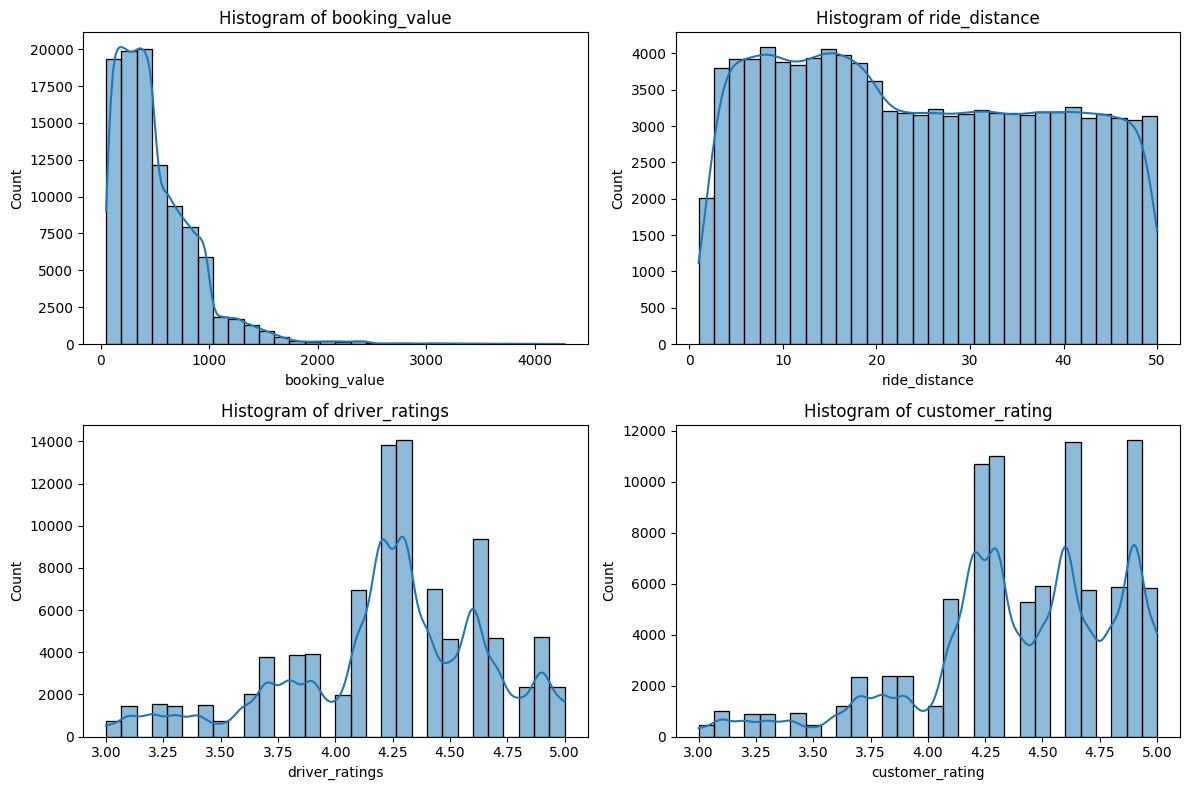

In [11]:
# Display title in Markdown
display(Markdown("<h1>📊 Histograms</h1>"))

# Columns to plot
cols_to_hist = ['booking_value', 'ride_distance', 'driver_ratings', 'customer_rating']

# Number of columns per row for subplot layout
n_cols = 2
n_rows = (len(cols_to_hist) + n_cols - 1) // n_cols

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 4))
axes = axes.flatten()  # Flatten in case of multiple rows

for i, col in enumerate(cols_to_hist):
    sns.histplot(clean_uber_df[col], kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# **🧐 Explanation**

The distribution of `booking_value` is heavily right-skewed, with the majority of orders falling between 100 and 1000. A few values appear at the lower end, suggesting the presence of potential outliers.

The `ride_distance` shows an overall uniform distribution, but there is a noticeable spike in the 10–20 range, which gives the distribution a slight right skew.

For `driver_ratings`, the distribution is slightly left-skewed and exhibits some spikes, likely due to the granularity of the rating system, such as ratings of 4.0, 4.2, and 4.5. Most ratings are high, concentrated between 4.0 and 5.0.

Similarly, `customer_rating` displays clear peaks at rounded values like 4.2, 4.5, and 4.8, probably because customers tend to round their ratings. The ratings are also concentrated in the higher range, between 4.0 and 5.0.


---


## **TL;DR**

**Both rating distributions are skewed toward higher values, booking_value is right-skewed with a few lower-end outliers, and ride_distance is mostly uniform but slightly skewed due to a concentration in the 10–20 range.**

## 📈 Checking The Data Outliers


<h1>📊 Box-Plot</h1>


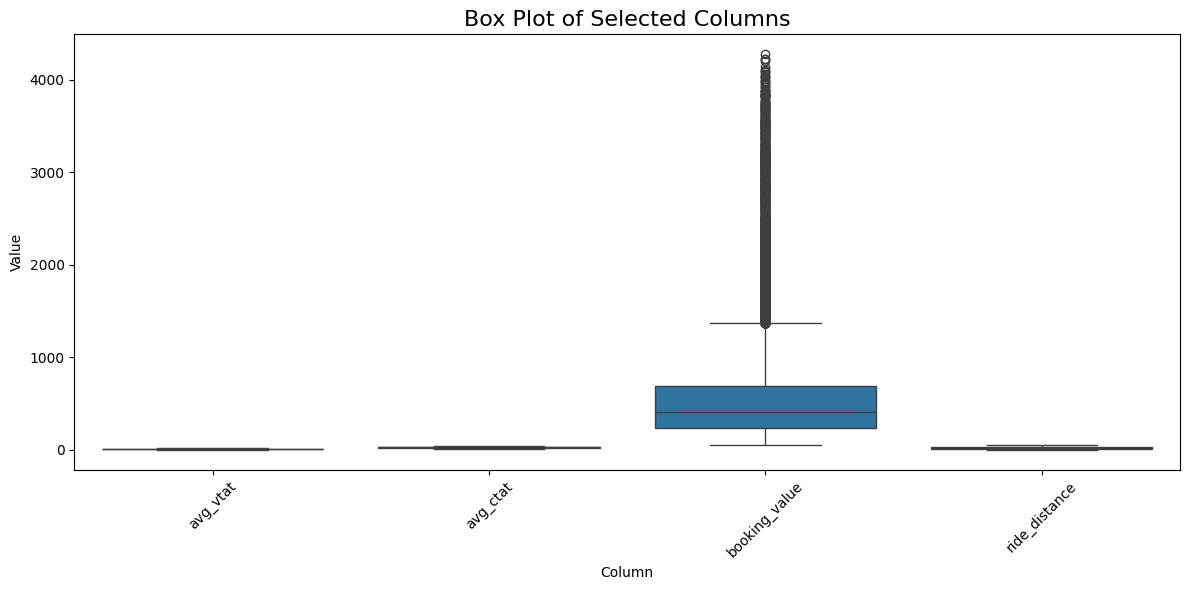


<h1>📊 Outlier Summary</h1>

⚠️ booking_value: 3,435 outliers (2.3%)<br>⚠️ avg_vtat: 0 outliers (0.0%)<br>⚠️ avg_ctat: 0 outliers (0.0%)<br>⚠️ ride_distance: 0 outliers (0.0%)


In [21]:
outlier_summary = count_outliers(base_uber_df, cols_to_box_plot)
outlier_summary_sorted = outlier_summary.sort_values(by='Outlier Percent', ascending=False)

# Convert to bullet text with HTML <br> for line breaks
outlier_text = "<br>".join([
    f"⚠️ {row['Column']}: {row['Outlier Count']:,} outliers ({row['Outlier Percent']:.1f}%)"
    for _, row in outlier_summary_sorted.iterrows()
])

df_melted = clean_uber_df[cols_to_box_plot].melt(var_name="Column", value_name="Value")

markdown(f"""
<h1>📊 Box-Plot</h1>
"""
)

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_melted, x="Column", y="Value")
plt.xticks(rotation=45)
plt.title("Box Plot of Selected Columns", fontsize=16)
plt.tight_layout()
plt.show()

markdown(f"""
<h1>📊 Outlier Summary</h1>

{outlier_text}
"""
)

# **🧐 Why not drop?**

Even though there are **3,435 outliers (2.3%)** in `booking_value`, they are not removed because these values are still valid data points that reflect actual bookings. Dropping them could bias the analysis, especially since booking values naturally vary and some extreme values (high or low) may represent real customer behavior, special orders, or promotions.


---


## **TL;DR**
**outliers are not necessarily errors they contain meaningful information, so removing them could distort the true picture of booking behavior.**